In [3]:
!git clone https://github.com/Archisman-07/Code-mixed-sentiment-analysis.git


Cloning into 'Code-mixed-sentiment-analysis'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 1.02 MiB | 5.94 MiB/s, done.


In [4]:
%cd /content/Code-mixed-sentiment-analysis

/content/Code-mixed-sentiment-analysis


In [ ]:
import json
import pandas as pd
import numpy as np
import re

In [6]:

import string
import warnings

from scipy import sparse
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_is_fitted, check_X_y

import sys
sys.path.insert(0, "../")

from hinglishutils import print_confusion_matrix

warnings.filterwarnings("ignore")

In [7]:
train=pd.read_json("/content/Code-mixed-sentiment-analysis/train.json")

In [8]:
train.describe()

,uid
count,13178.000000
mean,21766.108666
std,12124.959906
min,8.000000
25%,12985.750000
50%,21084.000000
75%,30781.750000
max,45274.000000


In [9]:
train.head(10)

,sentiment,text,uid,lang
3285,neutral,@ ANI Har cheez ke liye modi hi hi zimedaar ha...,7592,sw
2462,negative,Block fenk ke marunga agar BiggBoss ka chutiya...,4265,en
14203,positive,RT @ Harishnsui01 No Matter what result is You...,35974,en
14826,neutral,No Refunding at Several places chalta hai jyad...,38274,en
9460,positive,RT @ SupriyaRajput20 Lamberghini 🐂 chalayi jaa...,22061,en
11790,neutral,@ LambaAlka Jo log honhar hote hai sawal unhi ...,27778,id
392,positive,@ SeemeGRaja74 Wallaykum Assalam Wa RehmatUlla...,2148,id
1692,negative,@ MPRakeshSingh @ RajTiwa56444261 @ INCIndia @...,39051,id
12818,negative,@ waglenikhil What sort of a journo are you . ...,30272,en
15114,neutral,@ manakgupta @ LambaAlka Aisa kuch bhi nahi ha...,39366,sw


Data Pre-Processing

In [27]:
def cleaner(train):
    train["clean_text"] = train["text"]
    train["clean_text"] = (
        (train["clean_text"])
        .apply(lambda text: re.sub(r"RT\s@\s\w+", "", text))
        .apply(lambda text: re.sub(r"@", "mention", text))
        .apply(lambda text: re.sub(r"#", "hashtag", text))
        .apply(lambda text: re.sub(r"http\S+", "", text))
    )

    le = LabelEncoder()
    train["target"] = le.fit_transform(train["sentiment"])
    print(f"Classes : {le.classes_}")
    X_train, X_test, y_train, y_test = train_test_split(
        train["clean_text"].values,
        train["target"].values,
        test_size=0.10,
        random_state=0,
    )

    vect = TfidfVectorizer(
        strip_accents="unicode",
        ngram_range=(1, 2),
        max_df=0.75,
        min_df=3,
        sublinear_tf=True,
    )

    tfidf_train = vect.fit_transform(X_train)
    tfidf_test = vect.transform(X_test)

    return X_train, X_test, y_train, y_test, tfidf_train, tfidf_test, le.classes_

In [28]:
%time X_train, X_test, y_train, y_test, tfidf_train, tfidf_test, label_classes = cleaner(train)

Classes : ['negative' 'neutral' 'positive']
CPU times: user 1.26 s, sys: 84.7 ms, total: 1.34 s
Wall time: 1.34 s


In [17]:
X_train

array(['mention asha _ buzz agar kisi k liYe uh Compulsory ho jao To ? :heart_suit::speak-no-evil_monkey:  ',
       ' Jaise hi Modi ne aam Muslims ka vishwas jeetne ko baat kahi to jhtt se muslims ke thekedaron ke pait mein maror uthne lag …  ',
       'mention kamaalrkhan :victory_hand_light_skin_tone::thumbs_up::thumbs_up::thumbs_up::thumbs_up: nice Hrithik will always be superstar but I am not sure if super 30  ',
       ...,
       ' Yesterday is historytomorrow is a mysteryToday is a gift of Godwhich is wh we call it the present .... Jummah Mubarak …  ',
       "RT mention_ Natkhat _ Anki _ My and only my :panda: My teddy bear my panda my bundle of joy my tl's raunak my cutie cutie cutie pie I love everything abo …  ",
       'mention madhukishwar mention asadowaisi Aap thik se dekhe nhi video ko wo dra huavideo ke start me use dhmka ke bola ja rha h jo …  // t . co / o6QeAcFd0R  '],
      dtype=object)

NBSVM

NBSVM combines Naive Bayes with a linear model
such as SVM or Logistic Regression.

In [29]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        check_is_fitted(self, ["_r", "_clf"])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        check_is_fitted(self, ["_r", "_clf"])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y == y_i].sum(0)
            return (p + 1) / ((y == y_i).sum() + 1)

        self._r = sparse.csr_matrix(np.log(pr(x, 1, y) / pr(x, 0, y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(
            C=self.C, dual=self.dual, n_jobs=self.n_jobs
        ).fit(x_nb, y)
        return self

In [30]:
NBSVM = NbSvmClassifier(C=5, dual=False, n_jobs=-1)

In [31]:

def evaluate(model, tfidf_train, tfidf_test, y_train, y_test, s=None, with_noisy_labels= False):

    scores = cross_val_score(
        model, tfidf_train, y_train, cv=5, scoring="f1_macro"
    )
    print(f"Cross Validation Scores {scores}")

    if with_noisy_labels :
        _ = model.fit(tfidf_train, s)
    else:
        _ = model.fit(tfidf_train, y_train)
    pred = model.predict(tfidf_test)
    print("Valid accuracy:", round(accuracy_score(pred, y_test), 5))
    print("Valid f1_score:", round(f1_score(pred, y_test, average="macro"), 5))
    cm = confusion_matrix(pred, y_test)
    print_confusion_matrix(cm, class_names=label_classes)


Cross Validation Scores [nan nan nan nan nan]
Valid accuracy: 0.60091
Valid f1_score: 0.60498


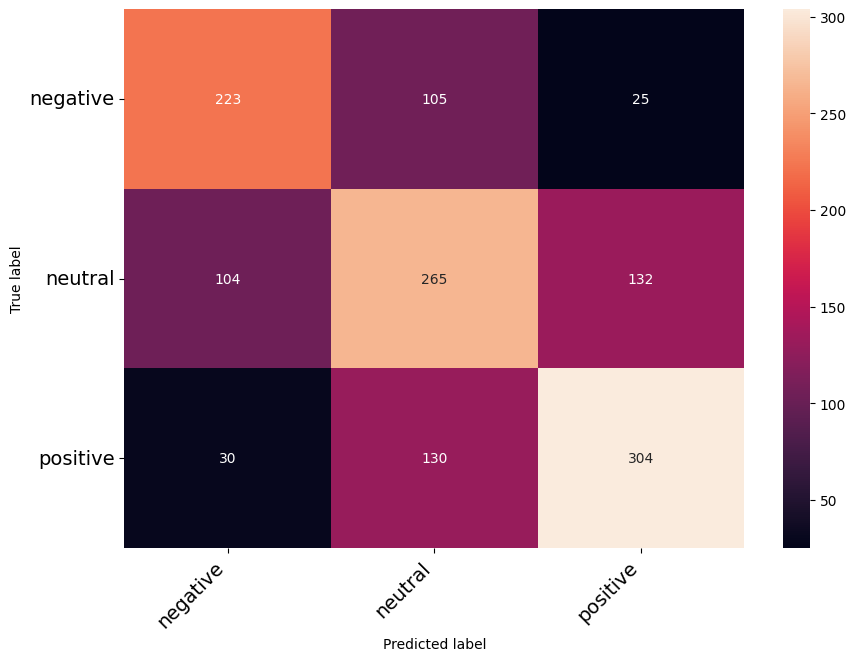

In [32]:
evaluate(NBSVM, tfidf_train, tfidf_test, y_train, y_test)

Regular Logistic Regression.

We implement the Regular Logistic Regression that maps the linear combination of input features to a prob-
ability score between 0 and 1 

In [35]:

LR = LogisticRegression(C=4, dual=False, solver="lbfgs", max_iter=1000)

Cross Validation Scores [0.59995694 0.6072789  0.5971579  0.58900659 0.57514937 0.59882354
 0.596798  ]
Valid accuracy: 0.59712
Valid f1_score: 0.59828


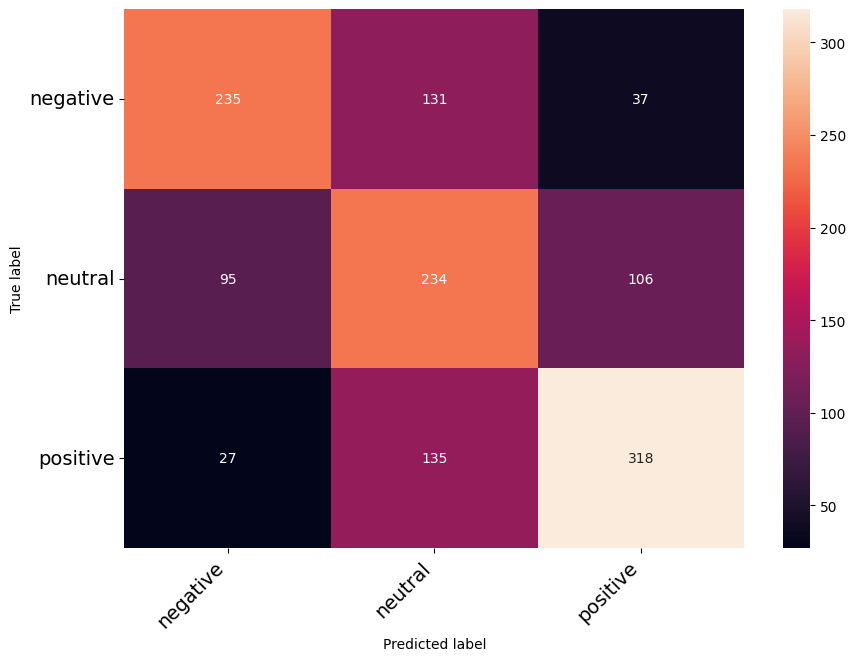

In [36]:

evaluate(LR, tfidf_train, tfidf_test, y_train, y_test)

Ensemble LR

We then implement the Ensemble Logistic Regression using a VotingClassifier

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [38]:
logistic1 = LogisticRegression(solver='liblinear', C=1.0, max_iter=100, random_state=1)
logistic2 = LogisticRegression(solver='lbfgs', C=0.5, max_iter=200, random_state=2)
logistic3 = LogisticRegression(solver='saga', C=0.1, max_iter=300, random_state=3)
logistic4 = LogisticRegression(solver='sag', C=0.05, max_iter=150, random_state=4)


In [39]:
ensemble = VotingClassifier(
    estimators=[
        ('logistic1', logistic1),
        ('logistic2', logistic2),
        ('logistic3', logistic3),
        ('logistic4', logistic4)
    ],
    voting='soft'
)

In [40]:
ensemble.fit(tfidf_train, y_train)

VotingClassifier(estimators=[('logistic1',
                              LogisticRegression(random_state=1,
                                                 solver='liblinear')),
                             ('logistic2',
                              LogisticRegression(C=0.5, max_iter=200,
                                                 random_state=2)),
                             ('logistic3',
                              LogisticRegression(C=0.1, max_iter=300,
                                                 random_state=3,
                                                 solver='saga')),
                             ('logistic4',
                              LogisticRegression(C=0.05, max_iter=150,
                                                 random_state=4,
                                                 solver='sag'))],
                 voting='soft')

In [41]:
y_pred = ensemble.predict(tfidf_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Ensemble Accuracy: {accuracy:.4f}")
print(f"Ensemble F1 Score: {f1:.4f}")

Ensemble Accuracy: 0.6138
Ensemble F1 Score: 0.6160


In [42]:

logistic1 = LogisticRegression(solver='liblinear', C=4.0, max_iter=1000, random_state=1)
logistic2 = LogisticRegression(solver='lbfgs', C=3.5, max_iter=1200, random_state=2)
logistic3 = LogisticRegression(solver='saga', C=6.0 , max_iter=3000, random_state=3)
logistic4 = LogisticRegression(solver='sag', C=5.0, max_iter=1500, random_state=4)
logistic5 = LogisticRegression(solver='lbfgs', C=4.0, max_iter=2000, random_state=2)

models = [('logistic1', logistic1), ('logistic2', logistic2), ('logistic3', logistic3), ('logistic4', logistic4), ('logistic5', logistic5)]

for name, model in models:
    model.fit(tfidf_train, y_train)
    y_pred = model.predict(tfidf_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

ensemble = VotingClassifier(estimators=models, voting='soft')


ensemble.fit(tfidf_train, y_train)


y_pred_ensemble = ensemble.predict(tfidf_test)

ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='macro')

print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble F1 Score: {ensemble_f1:.4f}")


logistic1 Accuracy: 0.6039
logistic2 Accuracy: 0.5956
logistic3 Accuracy: 0.5895
logistic4 Accuracy: 0.5941
logistic5 Accuracy: 0.5971

Ensemble Accuracy: 0.5948
Ensemble F1 Score: 0.5956


Hyperparameter Tuning with Grid Search for Logistic Regression is implemented here.


In [43]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score

param_grid = {
    'solver': ['liblinear', 'lbfgs', 'saga', 'sag'],
    'C': [0.01, 0.1, 1, 10, 100, 4],
    'max_iter': [1000, 2000, 300, 1500]
}


logistic = LogisticRegression()

grid_search = GridSearchCV(
    estimator=logistic,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(tfidf_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(tfidf_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

print("Test Accuracy with Best Parameters:", test_accuracy)
print("Test F1 Score with Best Parameters:", test_f1)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.6055649241146711
Test Accuracy with Best Parameters: 0.6168437025796661
Test F1 Score with Best Parameters: 0.6180688603457103


In this approach, we employ a Decision Tree Classifier for sentiment analysis

In [45]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(tfidf_train, y_train)

y_pred = clf.predict(tfidf_test)

y_pred = clf.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')


print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.4863
F1 Score: 0.4863


[Text(0.8858423863431771, 0.9973684210526316, 'x[17535] <= 0.073\ngini = 0.664\nsamples = 11860\nvalue = [3555, 4452, 3853]'),
 Text(0.7791560678086541, 0.9921052631578947, 'x[11742] <= 0.029\ngini = 0.662\nsamples = 10509\nvalue = [3389.0, 4058.0, 3062.0]'),
 Text(0.8324992270759156, 0.9947368421052631, 'True  '),
 Text(0.7132483289057332, 0.9868421052631579, 'x[1943] <= 0.059\ngini = 0.663\nsamples = 8574\nvalue = [2529, 3257, 2788]'),
 Text(0.6913609359185806, 0.9815789473684211, 'x[5118] <= 0.047\ngini = 0.662\nsamples = 8383\nvalue = [2378, 3225, 2780]'),
 Text(0.6683083078582093, 0.9763157894736842, 'x[15671] <= 0.066\ngini = 0.662\nsamples = 7992\nvalue = [2353, 3117, 2522]'),
 Text(0.6466465319828079, 0.9710526315789474, 'x[5675] <= 0.106\ngini = 0.66\nsamples = 7836\nvalue = [2225, 3097, 2514]'),
 Text(0.6167809130469585, 0.9657894736842105, 'x[7421] <= 0.072\ngini = 0.66\nsamples = 7636\nvalue = [2221, 3053, 2362]'),
 Text(0.5752493667667885, 0.9605263157894737, 'x[9730] <= 0

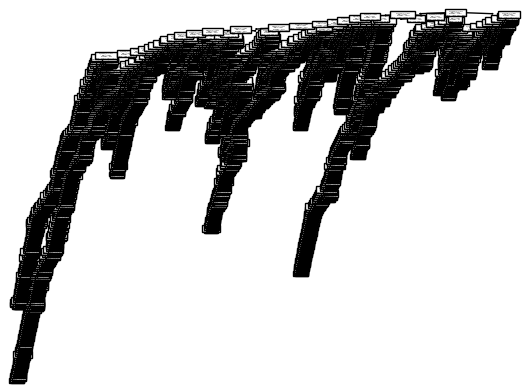

In [ ]:
tree.plot_tree(clf)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

'iris.pdf'

In this approach, we utilize a the ensemble learning method Random Forest Classifier for text classification

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(tfidf_train, y_train)
y_pred = rf.predict(tfidf_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Random Forest F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")


Random Forest Accuracy: 0.5888
Random Forest F1 Score: 0.5804


Gradient Boosting
is an ensemble technique that builds sequential decision trees, where each subsequent tree aims
to correct the errors made by the previous trees.

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb.fit(tfidf_train, y_train)
y_pred = gb.predict(tfidf_test)
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Gradient Boosting F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")


Gradient Boosting Accuracy: 0.6138
Gradient Boosting F1 Score: 0.6141
